# Laplacian Associative Memory (LAM) - KINGFISHER

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools, PIL.Image, scipy.linalg
from tqdm import tqdm

In [2]:
# np.random.seed(123)

In [3]:
FILENAME = "../data/images/kingfisher_resized.png"

In [4]:
class LAM():
    def __init__(self, N, P, prob, H, gamma, norm_mode):
        self.N = N
        self.P = P
        self.prob = prob
        self.H = H
        self.gamma = gamma
        self.norm_mode = norm_mode

        self.V = self.prob * (1-self.prob)
        self.NV = self.N * self.V
        
        # GENERATE PATTERNS
        self.xi = (np.random.rand(self.N, self.P) < self.prob).astype('float') # Binary dipole (+/-) input with sparsity
        self.xi_mean = np.sum(self.xi, axis=1, keepdims=True) / self.P
        self.xi_bias = self.xi - self.xi_mean

        # NORMALIZATION
        if self.norm_mode == "sym": # SYMMETRIC WEIGHTS
            Dnorm = np.diag(np.sum(self.H, axis=1)**-0.5)
            self.H = Dnorm @ self.H @ Dnorm
            self.Wauto = (self.xi_bias @ self.xi_bias.T) / self.NV
            self.Whetero = (self.xi_bias @ self.H @ self.xi_bias.T) / self.NV
            self.WG = self.gamma / self.N

        elif self.norm_mode == "asym": # ASYMMETRIC WEIGHTS
            Dnorm = np.diag(np.sum(self.H, axis=1)**-1) # Degree matrix
            self.H = Dnorm @ self.H # Hetero-associative weights
            self.Wauto = (self.xi @ self.xi.T) / self.NV # Local inhibition
            self.Whetero = (self.xi @ self.H @ self.xi.T) / self.NV # Excitatory
            self.WG = self.P * self.xi_mean @ self.xi_mean.T / self.NV + self.gamma / self.N # Global inhibition
        else:
            print("Error: Normalization mode 'sym' or 'asym' was not specified.")
            exit()

    def _step(self, z): # Heaviside step function
        return 0.5 * np.sign(z) + 0.5

    def _set_weight(self, a): # Decompose weights
        self.W = a * self.Wauto + self.Whetero - (a+1) * self.WG

    def simulate_single(self, a, eta, epochs, start_node, energycheck=True):
        self._set_weight(a)
        self.x = self.xi[:, start_node] + 0.0
        self.m_log = np.zeros([epochs, self.P])
        self.obj_log = np.zeros([epochs])

        for t in range(epochs):
            self.r = self._step(self.W @ self.x) # Threshold activation
            self.x += eta * (self.r - self.x) 
            self.m = (self.xi_bias.T @ self.x) / self.NV # Pattern overlap
            self.m_log[t,:] = self.m

            if energycheck:
                self.obj_log[t] = -(self.x).T @ self.W @ self.x / self.NV # Compute energy

        return (self.m_log, self.obj_log)

---

#### LOAD IMAGE

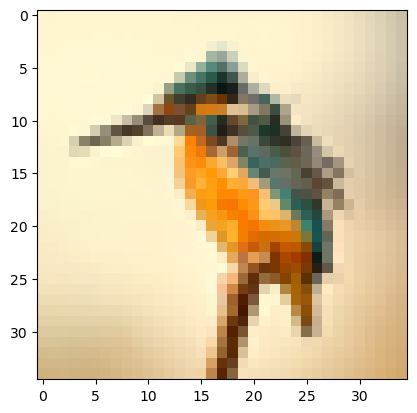

In [5]:
img = PIL.Image.open(FILENAME)
img = np.array(img, dtype=float) / np.max(img)
plt.imshow(img)

---

#### BUILD GRAPH

Each pixel is regarded as a node and link weights are determined by spatial proximity and similarity of RGB values.

In [6]:
n_row, n_col = img.shape[0], img.shape[1]
P = n_row * n_col # N_nodes

sigmaI = 0.1 
sigmaX = 4.0
r = 5

# ?
tmp = itertools.product(range(n_row), range(n_col))
combi_all = itertools.combinations(tmp, 2)
combi = [x for x in combi_all if np.sqrt((x[0][0] - x[1][0])**2 + (x[0][1] - x[1][1])**2) < r] # ?

edgelist_w = []
for x1,x2 in combi:
    n1 = int(x1[0] * n_col + x1[1])
    n2 = int(x2[0] * n_col + x2[1])
    simval = np.exp(-np.sum((img[x1[0],x1[1]] - img[x2[0],x2[1]])**2) / (sigmaI**2)) * np.exp(-((x1[0]-x2[0])**2 + (x1[1]-x2[1])**2) / (sigmaX**2)) # Construct link weights | Shi & Marik (2000)
    edgelist_w.append((n1, n2, simval))

# Adjacency matrix
W = np.zeros([P, P])
for x in edgelist_w:
    W[x[0],x[1]] = x[2]
    W[x[1],x[0]] = x[2]

Nnode= 1225 Nedge= 37010
169.05 point attactors
8882.40 bit capacity


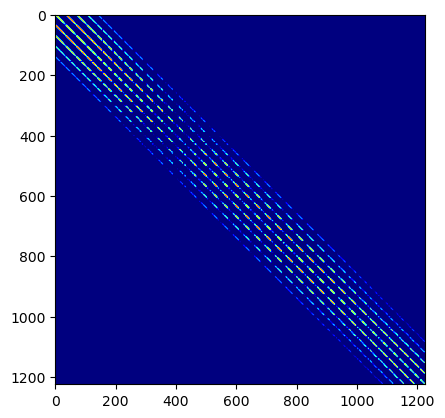

In [7]:
# Summary
print("Nnode=", P, "Nedge=", len(edgelist_w))
print(f"{P * 0.138:.2f} point attactors")
print(f"{0.24 * len(edgelist_w):.2f} bit capacity")
plt.imshow(W, cmap='jet')

---

#### LAPLACIAN & EIGENVECTORS

In [8]:
Dnorm = np.diag(np.sum(W, axis=1)**-1) # Normalized degree matrix

# Eigenvalue Laplacian
L = np.eye(P) - Dnorm @ W
e, v = scipy.linalg.eig(L)
e = np.real(e)
v = np.real(v)
order = np.argsort(e)
e = e[order]
v = v[:,order]

---

#### COMPUTE GRAPH

In [9]:
N = 4096                                                         # Neurons | Default: 30000
prob = 0.1                                                       # Sparsity
eta = 0.01                                                       # Epsilon (?)
epochs = 3000                                                    # Steps
gamma = 0.6                                                      # Inhibition ratio
a_arr = np.arange(-1.5, 3.1, 0.1)                                # Alpha

start_node = int(int(n_row/2) * n_col + int(n_row/2))            #

a_hist, m_hist = [], []
obj_hist = np.zeros([len(a_arr), epochs])

In [10]:
graph = LAM(N, P, prob, W, gamma, "asym")

In [11]:
# 2048 = 8min
# 8192 = 4hrs

for a_ind in tqdm(range(len(a_arr))):
    a = np.around(a_arr[a_ind], decimals=1)
    m_log, obj_log = graph.simulate_single(a, eta, epochs, start_node)
    m = m_log[-1,:]

    a_hist.append(a)
    m_hist.append(m)
    obj_hist[a_ind,:] = obj_log

100%|██████████| 46/46 [20:00<00:00, 26.11s/it]


---

#### PLOT RESULTS

Fig 1. Representative GL eigenvectors corresponding to segments obtained by LAM

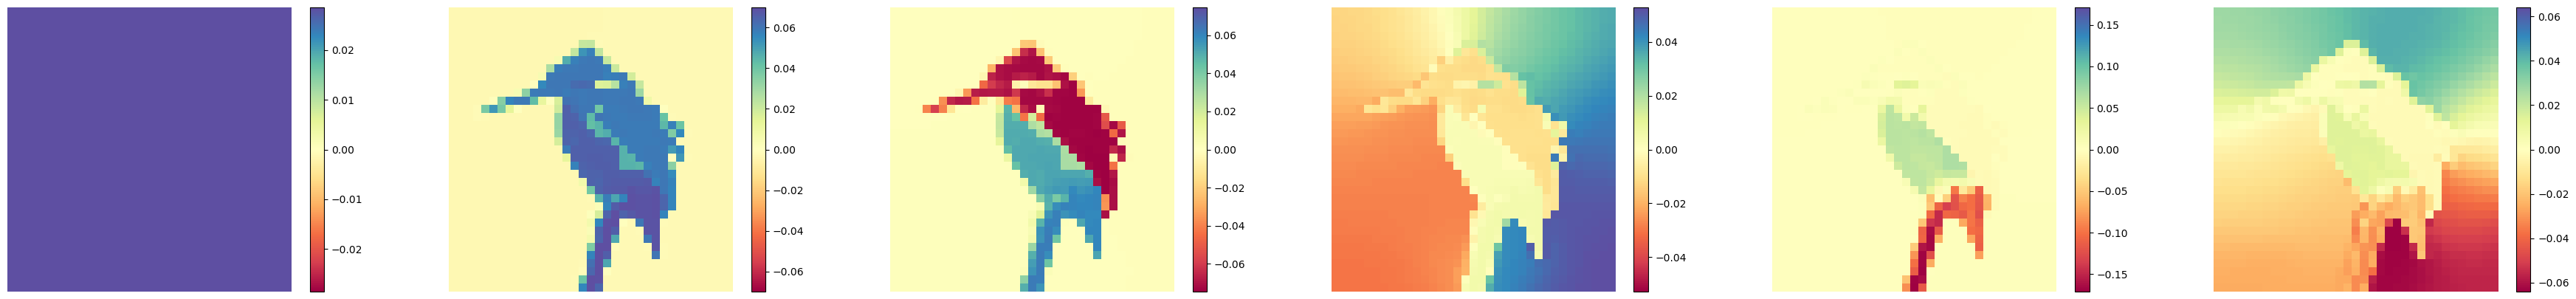

In [12]:
plt.figure(figsize=(45,5))
for k in range(6):
    color_max = np.max(np.abs(v[:,k]))
    plt.subplot(1, 6, k+1)
    plt.imshow(v[:,k].reshape((n_row,n_col)), cmap="Spectral", vmax=color_max, vmin=-color_max)
    plt.axis("off"), plt.colorbar()

Fig 2. Pattern overlaps obtained after the simulation of LAM at different *α* values

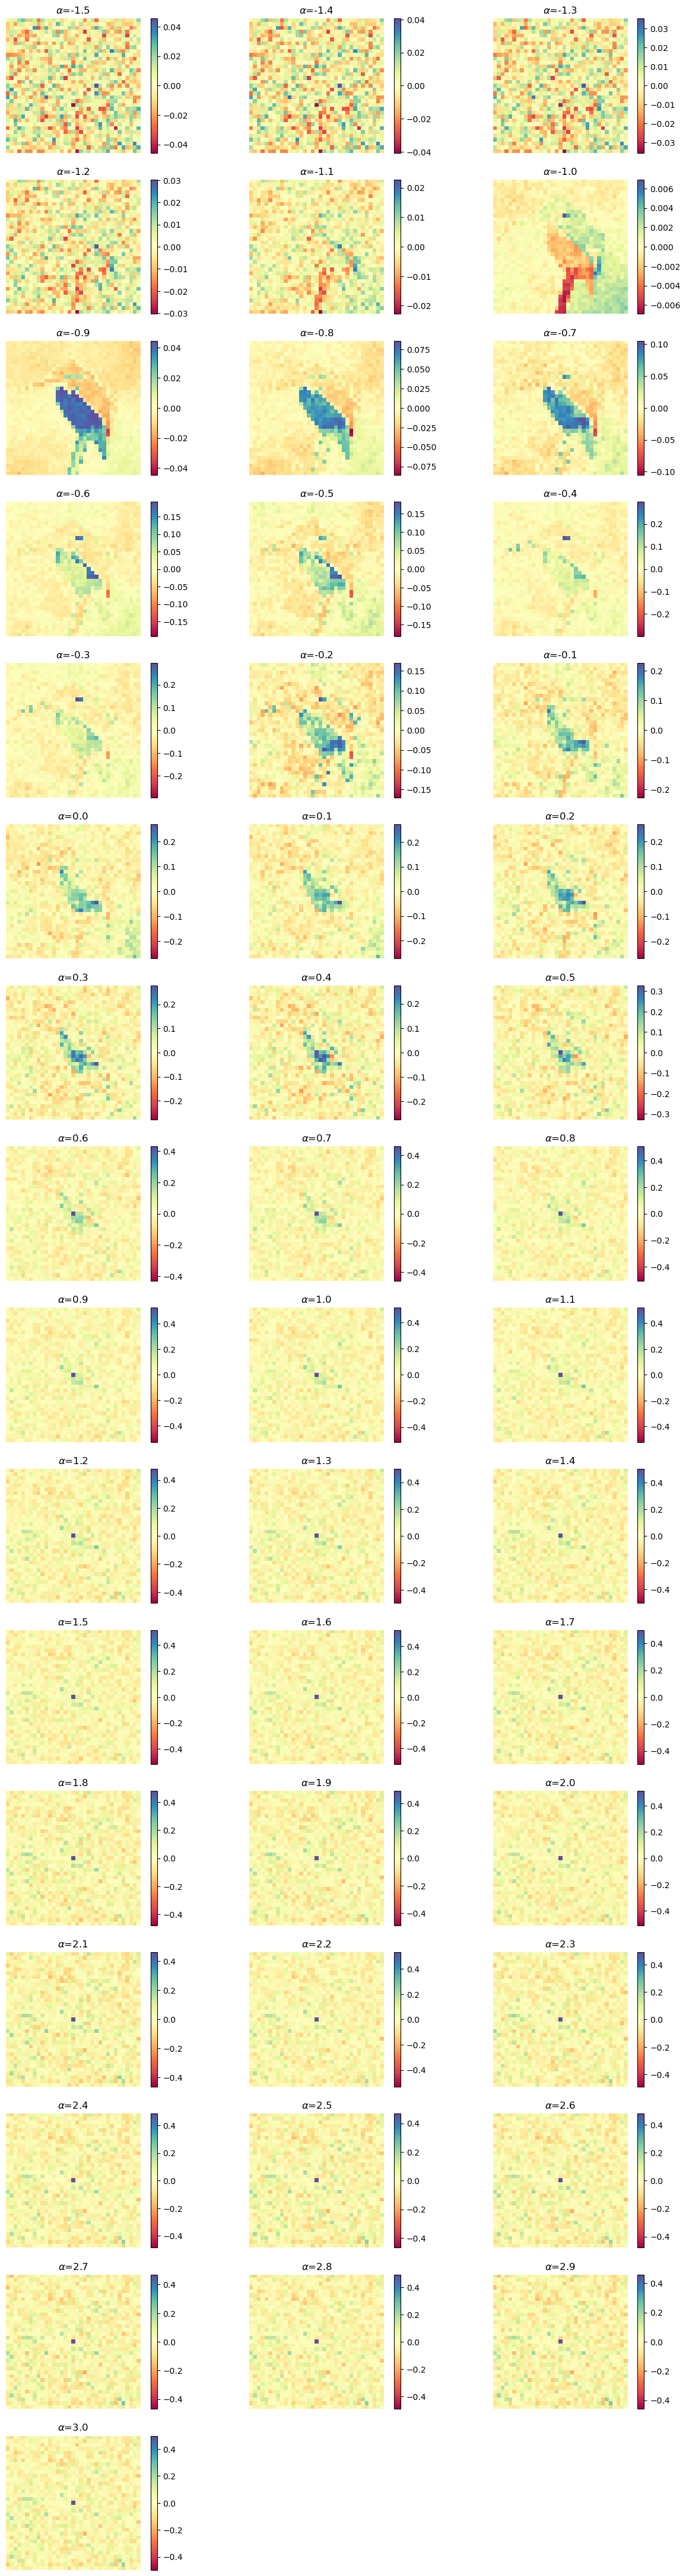

In [13]:
plt.figure(figsize=(15,70))
for a_ind in range(len(a_arr)):
    a = np.around(a_arr[a_ind], decimals=1)
    m = m_hist[a_ind]
    color_max = np.max(np.abs(m))

    plt.subplot(20, 3, a_ind+1)
    plt.imshow(m.reshape((n_row,n_col)), cmap="Spectral", vmax=color_max, vmin=-color_max)
    plt.axis("off"), plt.colorbar()
    plt.title(r"$\alpha$="+str(a))

---

#### PLOT STATISTICS

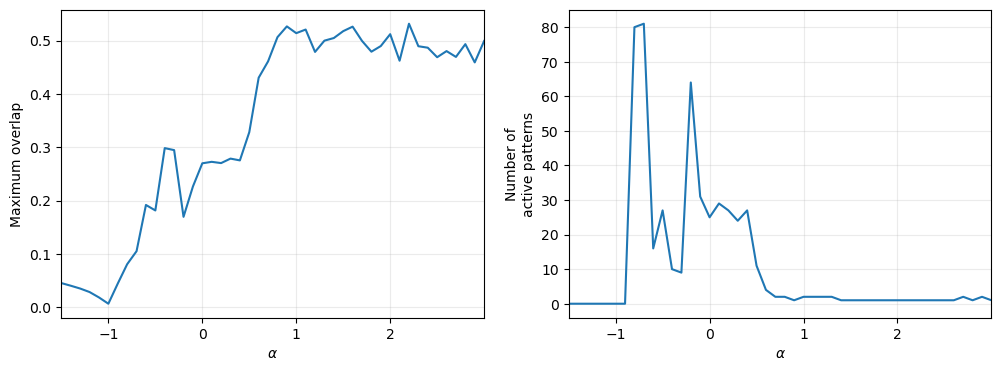

In [14]:
Na = len(a_arr)
max_overlap = np.zeros(Na)
Nactive = np.zeros(Na)

for a_ind in range(Na):
    m = m_hist[a_ind]
    max_m = np.max(m)
    max_overlap[a_ind] = max_m
    Nactive[a_ind] = np.mean(np.sum((m > 0.5*max_m) * (m > 0.05), axis=0))

xlim=[np.min(a_arr), np.max(a_arr)]
xticks=[-1, 0, 1, 2]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(a_arr, max_overlap)
plt.xlabel(r"$\alpha$"), plt.ylabel("Maximum overlap")
plt.xlim(xlim), plt.xticks(xticks)
plt.grid('on', alpha=0.25)

plt.subplot(1,2,2)
plt.plot(a_arr, Nactive)
plt.xlabel(r"$\alpha$"), plt.ylabel("Number of\nactive patterns")
plt.xlim(xlim), plt.xticks(xticks)
plt.grid('on', alpha=0.25)

---

#### EXPLAINED VARIANCE

The explained variance ratio in linear regressions of pattern overlaps by various numbers of GL eigenvectors. Colour indicates value of *α*.

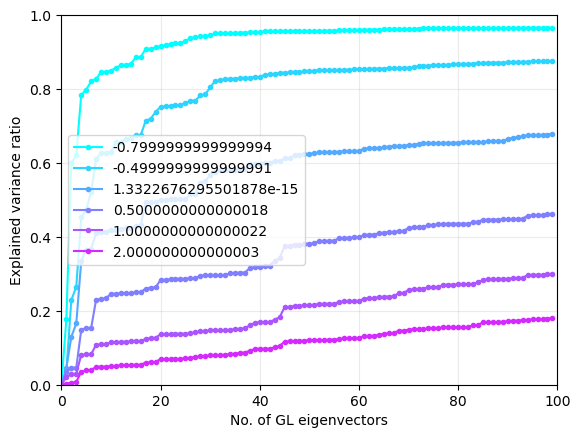

In [15]:
a_ind_pick=[7, 10, 15, 20, 25, 35]
a_arr=[a_arr[i] for i in a_ind_pick]
m_hist=[m_hist[i] for i in a_ind_pick]

p = 100
Rsquare = np.zeros([len(a_arr),p])

# EXPLAINED VAR (GL AND ATTRACTOR)
for a_ind in range(len(a_arr)):
    var = np.var(m_hist[a_ind])
    for i in range(p):
        coeff, res, rank, sing = np.linalg.lstsq(v[:,:i+1], m_hist[a_ind], rcond=None)
        Rsquare[a_ind,i] = 1-np.mean(res) / v.shape[0]/var

# SIMILARITY (OVERLAP AND BASES)
cm = plt.get_cmap("cool")
for i in range(len(a_arr)):
    plt.plot(Rsquare[i,:], ".-", label=str(a_arr[i]), color=cm(i/len(a_arr)))

plt.xlim([0,p]), plt.ylim([0,1])
plt.xlabel("No. of GL eigenvectors")
plt.ylabel("Explained variance ratio")
plt.legend()
plt.grid('on', alpha=0.25)